In [2]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto

wget: /sapps/opt/spack/linux-ubuntu16.04-x86_64/gcc-7.4.0/anaconda3-2020.11-q5jxtdwawrttqetvc2734tjx7v55v55y/lib/libuuid.so.1: no version information available (required by wget)
--2022-03-29 08:46:56--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12872 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  12.57K  --.-KB/s    in 0s      

2022-03-29 08:46:56 (69.4 MB/s) - ‘sentencepiece_model.proto’ saved [12872/12872]



In [7]:
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, T5ForConditionalGeneration, T5Tokenizer
import torch
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
from collections import Counter
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from pathlib import Path
import sentencepiece_model_pb2 as spmp

In [8]:
model_name = "google/mt5-base"
save_model_name = 'det5-base'
save_dir = Path('models')

tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)

# update local paths if necessary
de_sents = 'data/newscrawl/deu_newscrawl-public_2019_1M/deu_newscrawl-public_2019_1M-sentences.txt'
en_sents = 'data/newscrawl/eng_newscrawl-public_2018_1M/eng_newscrawl-public_2018_1M-sentences.txt'

In [9]:
def sanity_check(model, tokenizer):
    inputs = tokenizer('Der <extra_id_0> geht  <extra_id_1> Park.', return_tensors='pt')
    with torch.no_grad():
        hypotheses = model.generate(
            **inputs, 
            do_sample=False, 
            num_beams=3,
            num_return_sequences=3,
            max_length=32,
        )
    for h in hypotheses:
        print(tokenizer.decode(h))
    return

In [10]:
sanity_check(model, tokenizer)

<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neue <extra_id_8> in den <extra_id_9> neue Park <extra_id_10>
<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neuer <extra_id_8> in den <extra_id_9> neuer <extra_id_10> in
<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neue <extra_id_8> in den <extra_id_9> neue <extra_id_10> in


In [11]:
print(tokenizer.vocab_size)

250100


In [12]:


def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print("------")
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print("------")
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))



582401280
192086016
------
encoder
277040256
84953472
------
decoder
305361024
113274240
192086016


In [14]:


print(msize(model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))



0.32981729710484153
0.32981729710484153


In [15]:
df_de = pd.read_csv(de_sents, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_de.columns = ['idx', 'text']
print(len(df_de))
df_de.sample(5)


1000000


,idx,text
486757,486758,"""Es ist eine Frechheit, als Letzte von der Maßnahme zu erfahren, welche die Schule erheblich betrifft"", sagte Schulsprecherin Doreen Kreil."
10034,10035,"Aber was ich zumindest erstaunlich finde, ist, dass diese Frau Leimbach-Knorr, die ja wirklich nur eine kleine Rolle ist, so bei den Kindern bei den Jugendlichen eingeschlagen hat."
199138,199139,"Dass sich Versicherungsvertreter und Richter auf die Detektiv-Aussagen stützen, sei stossend."
797021,797022,"Seit einigen Tagen gab es das Gerücht, jetzt ist es amtlich: Viktoria Kelsterbach wird seine Erste Mannschaft am Ende der Saison aus der Fußball-Verbandsliga zurückziehen."
970326,970327,"""Wir werden sicherlich keinen Ausflug nach Rückers machen, sondern alles daran setzen, Punkte mit in den Vogelsberg zu bringen"", so Glitsch abschließend."


In [16]:
df_en = pd.read_csv(en_sents, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
print(len(df_en))
df_en.sample(5)



1000000


,idx,text
536448,536449,"“Of course we would like to have some security cameras, extra lighting, but that’s out of our budget."
458982,458983,"Kylie Jenner lookalike Demi was first propelled into the spotlight when she was linked to the reality star's ex, rapper Tyga, after they split."
568070,568071,Part of the venue's concept was drawing the national teams to Kansas City on a more regular basis.
148599,148600,Cde Khaya Moyo described the venue as significant because Manicaland sent many sons and daughters of the soil across the border into Mozambique to join the liberation struggle.
615475,615476,Sending you deep gratitude and support from Swarthmore.


In [17]:

cnt_de = Counter()
# for text in tqdm(df_de.text):
for text in df_de.text:
    cnt_de.update(tokenizer.encode(text))

cnt_en = Counter()
# for text in tqdm(df_en.text):
for text in df_en.text:
    cnt_en.update(tokenizer.encode(text))



In [18]:

print(len(cnt_de), len(cnt_de)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
common = len(set(cnt_de.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_de))



67044 0.2680687724910036
73890 0.29544182327069174
53213 0.7937026430403914


In [19]:


print('de')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_de.most_common(top)) / sum(cnt_de.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))



de
10000 0.9596382358959944
20000 0.988122922424769
30000 0.9953906308584815
en
10000 0.9481541225982594
20000 0.9812459830182233
30000 0.9920559411977609


In [20]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

In [21]:


print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_de.most_common(40)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(40)]))



['▁', '</s>', '.', ',', 'en', '▁der', '▁die', 's', '▁und', 't', 'e', '-', '▁in', 'n', '▁den', 'er', '▁zu', '▁mit', '▁das', '▁auf', '▁ist', '▁von', '▁ein', '▁im', '▁sich', '▁für', '▁Die', '▁nicht', 'te', '▁eine', '▁dem', '▁des', '▁es', '▁an', ':', '▁er', 'auch', 'ten', '▁aus', '▁bei']
['▁', '▁the', '</s>', '.', ',', 's', '▁to', '▁and', '▁of', 'a', '▁in', 'ed', '▁is', '▁for', '’', '▁that', 'ing', '-', '▁on', '▁The', '▁with', '▁was', 'y', '▁at', '▁be', '▁it', '▁“', 'd', 'ly', '▁as', 'e', "'", '▁are', '▁I', '▁have', '▁from', '▁by', '▁said', '▁will', '▁has']


In [22]:


new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_de.most_common(30_000)):
    if len(new_tokens) == 39_900:
        print(i, 'DE tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)



35596


In [23]:


len(kept_ids) / tokenizer.vocab_size



0.14232706917233107

Text(0, 0.5, 'old id of token')

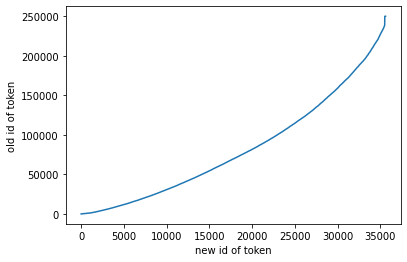

In [24]:


plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token')



In [25]:

new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)


for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]



model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight




In [26]:


print(msize(model), msize(model) / original_size)



252904704 0.4342447599016266


In [27]:


!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto



wget: /sapps/opt/spack/linux-ubuntu16.04-x86_64/gcc-7.4.0/anaconda3-2020.11-q5jxtdwawrttqetvc2734tjx7v55v55y/lib/libuuid.so.1: no version information available (required by wget)
--2022-03-29 08:58:37--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12872 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto.1’

sentencepiece_model 100%[===================>]  12.57K  --.-KB/s    in 0s      

2022-03-29 08:58:38 (68.0 MB/s) - ‘sentencepiece_model.proto.1’ saved [12872/12872]



In [28]:


!protoc --python_out=. sentencepiece_model.proto



In [29]:

smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in range(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open(str(save_dir / 'new_sp.model'), 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 35596
35596


In [30]:
new_tokenizer = MT5Tokenizer(str(save_dir / 'new_sp.model'), extra_ids=0)
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = f'cointegrated/{save_model_name}'
model.config



MT5Config {
  "_name_or_path": "cointegrated/det5-base",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.16.2",
  "use_cache": true,
  "vocab_size": 35596
}

In [31]:
new_tokenizer.save_pretrained(str(save_dir / f'{save_model_name}'))
model.save_pretrained(str(save_dir / f'{save_model_name}'))


In [32]:


model = MT5ForConditionalGeneration.from_pretrained(str(save_dir / f'{save_model_name}'))
tokenizer = MT5Tokenizer.from_pretrained(str(save_dir / f'{save_model_name}'))

sanity_check(model, tokenizer)
# note: this should resemble outputs from initial sanity check above!

<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neue <extra_id_8> in den <extra_id_9> neue Park <extra_id_10>
<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neuer <extra_id_8> in den <extra_id_9> neuer <extra_id_10> in
<pad> <extra_id_0> Park <extra_id_1> in den <extra_id_2> in den <extra_id_3> liegt <extra_id_4> in den <extra_id_5> neue <extra_id_6> in den <extra_id_7> neue <extra_id_8> in den <extra_id_9> neue <extra_id_10> in
